In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread,imshow
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
#from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten

In [2]:
folders=glob('chest_xray\\*')
folders

['chest_xray\\test', 'chest_xray\\train', 'chest_xray\\val']

In [3]:
folders_train=glob('chest_xray\\train\\*')
folders_train

['chest_xray\\train\\NORMAL', 'chest_xray\\train\\PNEUMONIA']

In [4]:
pneumonia=os.listdir(folders_train[1])
normal=os.listdir(folders_train[0])

In [5]:
len(pneumonia),len(normal)

(3875, 1341)

# Pneumonia Chest

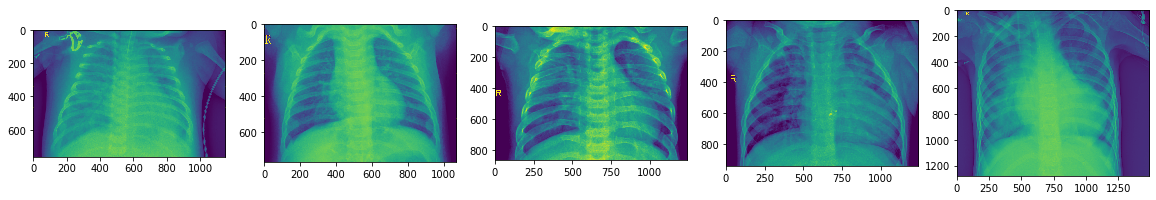

In [6]:
fig,ax=plt.subplots(nrows=1,ncols=5,figsize=(20,20))

for i in range(5):
    img=imread(folders_train[1]+"\\"+pneumonia[i])
    ax[i].imshow(img)

# Normal Chest

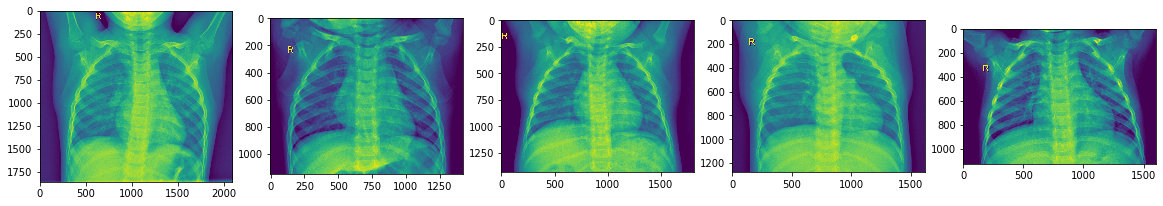

In [7]:
fig,ax=plt.subplots(nrows=1,ncols=5,figsize=(20,20))

for i in range(5):
    img=imread(folders_train[0]+"\\"+normal[i])
    ax[i].imshow(img)

# Image Preprocessing

In [8]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True)

test_datagen=ImageDataGenerator(rescale=1./225)

In [9]:
train_dataset=train_datagen.flow_from_directory('chest_xray/train',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')

Found 5216 images belonging to 2 classes.


In [10]:
test_dataset=test_datagen.flow_from_directory('chest_xray/test',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')

Found 624 images belonging to 2 classes.


# Model Building

In [11]:
vgg16=VGG16(input_shape=(224,224,3),weights='imagenet',include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
for layers in vgg16.layers:
    layers.trainable=False

In [14]:
x=Flatten()(vgg16.output)
final_layer=Dense(units=2,activation='softmax')(x)
model=Model(inputs=vgg16.input,outputs=final_layer)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
model.fit_generator(train_dataset,
                    validation_data=test_dataset,
                    epochs=5,
                    steps_per_epoch=len(train_dataset),
                    validation_steps=len(test_dataset))

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
163/163 [==============================] - 4207s 26s/step - loss: 0.2528 - acc: 0.9018 - val_loss: 0.2637 - val_acc: 0.9006
Epoch 2/5
163/163 [==============================] - 6264s 38s/step - loss: 0.1653 - acc: 0.9381 - val_loss: 0.2756 - val_acc: 0.9151
Epoch 3/5
163/163 [==============================] - 2621s 16s/step - loss: 0.1232 - acc: 0.9582 - val_loss: 0.3009 - val_acc: 0.9119
Epoch 4/5
163/163 [==============================] - 2638s 16s/step - loss: 0.1214 - acc: 0.9548 - val_loss: 0.2955 - val_acc: 0.9103
Epoch 5/5
163/163 [==============================] - 2367s 15s/step - loss: 0.1156 - acc: 0.9542 - val_loss: 0.3466 - val_acc: 0.9038


In [16]:
model.save('pneumonia_model.h5')

In [20]:
img=image.load_img('chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg',target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
classes=model.predict(img_data)
classes

array([[1., 0.]], dtype=float32)